In [1]:
project_folder = ''

In [5]:
from custompackage.load_data import *
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
# override SSL certificate verification failure
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
bs = 256
weighting = 'paired'
trials = 10
classes = 10
ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']

#paired_test = np.zeros((len(ds_set), trials, 10, 10))
paired_test = np.load(project_folder+"results/confused_pairs_all.npy", allow_pickle=True)

# For each 10-class dataset
for k, ds in enumerate(ds_set):
    # Go through each class
    for t1 in range(classes):

        # and pair it with every other class
        for t2 in range(t1 + 1, classes):

            if paired_test[k, -1, t1, t2] != 0:
                continue

            # Load the binary classification dataloaders
            trainloaders, validloaders, testloader = dataset_weighted_split_all(bs, t1, t2, weighting, trials, ds)
            X_test = testloader.dataset.tensors[0]
            y_test = testloader.dataset.tensors[1]

            for m in range(trials):
                # Assign entirety of the datasets within each dataloader to a variable
                X_train = trainloaders[m].dataset.tensors[0]
                y_train = trainloaders[m].dataset.tensors[1]

                # initialize lda
                lda = LinearDiscriminantAnalysis()

                # fit to images, labels
                lda.fit(X_train, y_train)

                # see accuracy for validation set
                score_test = lda.score(X_test, y_test)

                print(ds, m, t1, t2, score_test)

                #Record keeping

                paired_test[k, m, t1, t2] = score_test

                np.save(project_folder+'results/confused_pairs_all.npy', paired_test)

RESULTS:


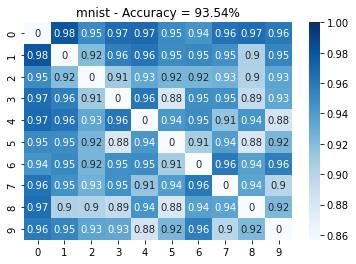

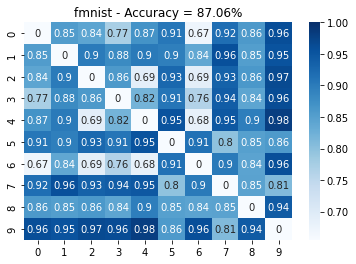

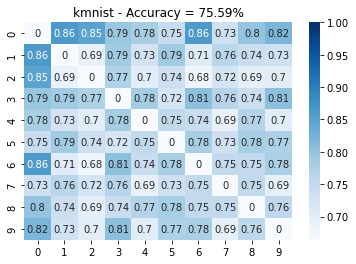

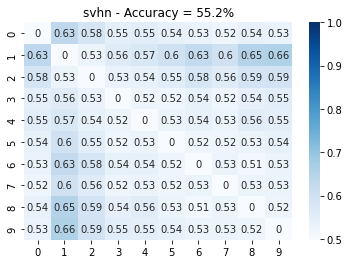

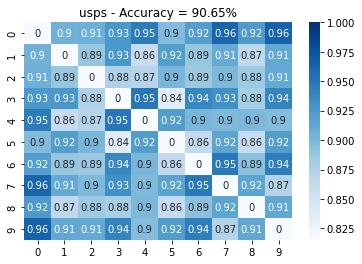

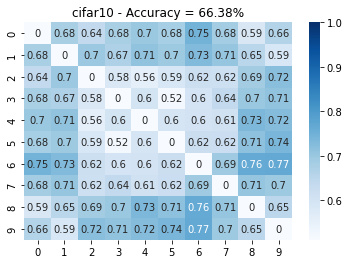

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

ds_set = ['mnist', 'fmnist', 'kmnist', 'svhn', 'usps', 'cifar10']
paired_test = np.load(project_folder+'results/confused_pairs_all.npy', allow_pickle=True)

print("RESULTS:")
for k, ds in enumerate(ds_set):
    num_classes = len(paired_test[k, 0])
    heatmap_matrix = np.zeros((num_classes, num_classes))
    for t1 in range(num_classes):
        for t2 in range(t1+1, num_classes):
            heatmap_matrix[t1, t2] = np.mean(paired_test[k, :, t1, t2])
            heatmap_matrix[t2, t1] = heatmap_matrix[t1, t2]

    min_acc = .975 * min(heatmap_matrix[np.nonzero(heatmap_matrix)])
    plt.figure()
    ax = sns.heatmap(heatmap_matrix, annot=True, cmap='Blues', vmin=min_acc, vmax=1)
    ax.set_title(ds + f" - Accuracy = {round(np.mean(heatmap_matrix[np.nonzero(heatmap_matrix)]) * 100, 2)}%")
